In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import pylab as p

# genetIC doesn't rely on pynbody, but the analysis in this tutorial will. Install with pip install pynbody
import pynbody

genetIC tutorial
================

This tutorial guides you through making a simple zoom initial conditions, and genetically modified versions of it.

We will use gadget-4 for running simulations, and pynbody for analysis. However, some minor modifications would allow you to use other simulation codes (RAMSES, ChaNGa etc) and other analysis packages.

Pre-requisites
--------------

1. Install python + jupyter lab. Hopefully you already have these if you're reading this, but if not, take a look at https://jupyter.org. Information about using python and jupyter is ubiquitous on the web.

2. Install pynbody, assuming you want to go through with the analysis steps in this notebook. If you haven't already got it, you should be able to do it by running `pip install pynbody` at your command line.

3. Install gadget-4. This is, in a sense, optional -- you can work through the steps below without actually running the simulations yourself, if you are happy to take my results on trust. Gadget-4 can be downloaded at https://wwwmpa.mpa-garching.mpg.de/gadget4/. Inside the tutorial folder, under `gadget4_configuration`, you'll find a `Config.sh` which can be placed in Gadget-4's root directory, and is suitable for building a Gadget-4 configuration compatible with this tutorial. 

4. Obtain and build `genetIC`. If you haven't already, you can obtain the source and ancillary files (including this tutorial) at https://github.com/pynbody/genetIC/, with specific releases at https://github.com/pynbody/genetIC/releases/. There, you will also find a comprehensive user manual PDF.

**Option 1: compile for your machine**. Before building `genetIC`, you need to make sure `gsl` and `fftw3` are available on your machine, as well as an up-to-date C++ compiler that supports OpenMP. These things can be installed using your standard package manager (e.g. apt, macports, brew etc) and anyway you need them for Gadget-4 too. And then, you can build using `make`. If you have any problems, try consulting the latest user manual at https://github.com/pynbody/genetIC/releases/. 

**Option 2: use docker to download a pre-built containerized binary**. If you prefer not to build it yourself, you can also use a docker image. You can download and install docker for any system here: https://www.docker.com. Once you are up and running you can go into a terminal and do

```
docker pull apontzen/genetic
genetIC() {                                                                           
   docker run --rm -v $(pwd)/../:/w/ apontzen/genetic /w/$(basename $(pwd))/$1
}
```

and now you can run genetIC from the terminal as though it's installed on your own machine, just by typing `genetIC`!

Generating ICs for a uniform volume
-----------------------------------

The first step is to generate ICs for a uniform volume. In the `tutorial` folder, head into `step_1_uniform` and you'll find a `paramfile.txt`, which contains the commands to `genetIC`. It's heavily commented, so take a look through. Then, generate the ICs by typing `genetIC paramfile.txt`. You should see some messages scroll past, a bit like this:

In [2]:
!../genetIC/genetIC/genetIC step_1_uniform/paramfile.txt 
# note you'll need to change the path to the genetIC binary here, or alternatively run genetIC from a terminal window

genetIC v1.3.6, compiled: Jun 18 2022, 09:52:50
                 runtime: Jun 23 2022, 20:08:30

git HEAD:eeb7f12
 2022-06-23 20:08:30   
 2022-06-23 20:08:30   Limiting number of FFTW Threads to 8, because FFTW on Mac OS seems to become slow beyond this point.
 2022-06-23 20:08:30   To disable this behaviour, recompile with -DIGNORE_APPLE_FFTW_THREAD_LIMIT
 2022-06-23 20:08:30   OpenMP parts of the code will still run with 20 threads.
 2022-06-23 20:08:30   
 2022-06-23 20:08:30   Initialized the base grid:
 2022-06-23 20:08:30     Box length            = 50 Mpc/h
 2022-06-23 20:08:30     n                     = 128
 2022-06-23 20:08:30     dx                    = 0.390625
 2022-06-23 20:08:30   Drawing random numbers (base grid)
  100% |--------------------------------------------------|                     
 2022-06-23 20:08:30   Calculating particles from overdensity fields...
 2022-06-23 20:08:30   Writing output; number dm particles=2097152, number gas particles=0
 2022-06-23 20:

Running the uniform volume simulation
-------------------------------------

Next, you need to run the simulation! This depends on your exact setup with gadget, but if you have built it with the `Config.sh` that I pointed you to above, it should be pretty straight-forward. You can use the `gadget_param.txt` parameter file provided in the `step_1_uniform` folder and it will write a series of outputs into a `gadget_output` folder. 

Let's take a look at the results. (If you don't want to use `pynbody` for the next step, you'll need to adapt these commands).

SimArray([[ 7734858.  , 19561126.  , 11251942.  , ...,  2143433.5 ,
            2513156.8 ,  2330446.  ],
          [ 5485112.  ,  9256240.  ,  5784512.5 , ...,  3589597.2 ,
            3404161.2 ,  2775199.  ],
          [ 4454700.  ,  4668770.  ,  5591954.  , ...,  4097949.  ,
            3043856.8 ,  2367057.2 ],
          ...,
          [ 2207749.2 ,  1912139.  ,  1328470.4 , ...,  1186361.2 ,
            1189753.9 ,  1150664.  ],
          [ 2576755.  ,  1995820.4 ,  1244723.4 , ...,  1053418.9 ,
            1048282.3 ,  1008428.8 ],
          [ 2359375.8 ,  1846845.8 ,  1266407.  , ...,   936573.8 ,
             940983.94,   908656.3 ]], dtype=float32, 'Msol kpc**-2')

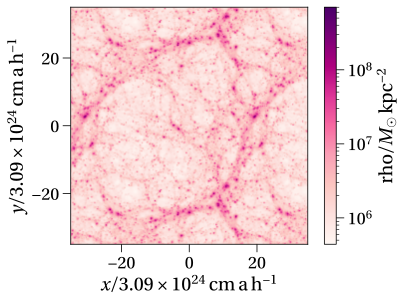

In [3]:
p.set_cmap('RdPu')
f = pynbody.load("step_1_uniform/gadget_output/snapshot_047.hdf5") # this is the final output
pynbody.plot.sph.image(f.dm, width="70 Mpc a h^-1", units="Msol kpc^-2") 
# this should show us the whole simulation, including a bit of the wrap-around so we can see the tiling

Gadget was configured to run with the Subfind halo finder, so we can get the FOF groups like this:

In [4]:
h=f.halos()

# get an array of masses and positions for the first 2000 halos

masses = np.array([float(h[i].properties['GroupMass'].in_units("Msol")) for i in range(2000)])
positions = np.array([h[i].properties['GroupPos'] for i in range(2000)])


# look for ~1e12 Msol/h halos, and also we're going to avoid neighbours greater than ~0.5e12 Msol/h
target_mass_range = (masses>1e12) & (masses<2e12)
neighbour_mass_range = (masses>0.5e12) 

# make a matrix of distances between target halos and potential neighbour halos
distances_to_neighbour = np.linalg.norm(
    positions[np.newaxis,target_mass_range] - positions[neighbour_mass_range,np.newaxis],
    axis=2)

# We don't want to make the mistake of having the nearest neighbour actually just the halo itself!
distances_to_neighbour[distances_to_neighbour==0]=np.inf 

# Now we'll an array of the distances to the closest neighbour for each halo in our target mass range
distance_to_closest_neighbour = distances_to_neighbour.min(axis=0)

# Let's say a viable candidate is one where there is no neighbour within 3 Mpc/h
candidates = np.where(target_mass_range)[0][distance_to_closest_neighbour>3]

# And then choose randomly a halo to zoom on from those candidates
np.random.seed(2)
my_halo_choice = np.random.choice(candidates)


**Drumroll, please!** Let's reveal the chosen halo:

In [5]:
my_halo_choice

694

Lovely, let's now take a look at our chosen halo

SimArray([[ 166702.38 ,  164308.48 ,  161914.56 , ...,   74655.875,
             74405.02 ,   74154.17 ],
          [ 168613.06 ,  166178.19 ,  163743.28 , ...,   74999.21 ,
             74745.48 ,   74491.73 ],
          [ 170523.77 ,  168047.86 ,  165571.97 , ...,   75342.56 ,
             75085.92 ,   74829.29 ],
          ...,
          [  76386.54 ,   76302.03 ,   76217.555, ..., 1406598.2  ,
           1388240.4  , 1369882.1  ],
          [  75514.38 ,   75444.01 ,   75373.65 , ..., 1428829.6  ,
           1410163.1  , 1391497.2  ],
          [  74642.234,   74585.98 ,   74529.71 , ..., 1451060.9  ,
           1432086.5  , 1413112.   ]], dtype=float32, 'Msol kpc**-2')

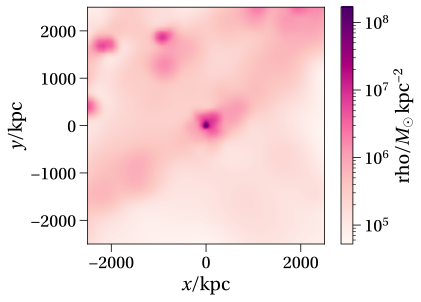

In [6]:
pynbody.analysis.halo.center(h[my_halo_choice], vel=False)
f.physical_units()
pynbody.plot.sph.image(f.dm[pynbody.filt.Sphere("5 Mpc")], width="5 Mpc", units="Msol kpc^-2")

**Eugh! It's a blob!** But then, the whole point is we're now going to make a zoom simulation. So, let's get started; how big is the virial radius?

In [7]:
pynbody.analysis.halo.virial_radius(f.dm)

SimArray(371.72296906, 'kpc')

Let's generate a zoom out to ~2 virial radii, 750 kpc. The key is to get the indexes of the
particles _in the initial conditions_, which gadget stores as an order integer. Pynbody
calls this `iord` though if you are using another library to access the HDF files directly, 
it's called `ParticleIDs`.

In [8]:
particles_to_zoom = f.dm[pynbody.filt.Sphere("750 kpc")]['iord']

np.savetxt(f"step_2_zoom/zoom_particles_{my_halo_choice}.txt", particles_to_zoom, fmt="%d")

Generating ICs for the zoom simulation
--------------------------------------

Having selected the particles to zoom on, we can now generate the zoom ICs. 

Take a look at step_2_zoom/paramfile.txt and its commentary, and then we can generate it!

In [9]:
!../genetIC/genetIC/genetIC step_2_zoom/paramfile.txt

genetIC v1.3.6, compiled: Jun 18 2022, 09:52:50
                 runtime: Jun 23 2022, 20:08:36

git HEAD:eeb7f12
 2022-06-23 20:08:36   
 2022-06-23 20:08:36   Limiting number of FFTW Threads to 8, because FFTW on Mac OS seems to become slow beyond this point.
 2022-06-23 20:08:36   To disable this behaviour, recompile with -DIGNORE_APPLE_FFTW_THREAD_LIMIT
 2022-06-23 20:08:36   OpenMP parts of the code will still run with 20 threads.
 2022-06-23 20:08:36   
 2022-06-23 20:08:37   Initialized the base grid:
 2022-06-23 20:08:37     Box length            = 50 Mpc/h
 2022-06-23 20:08:37     n                     = 128
 2022-06-23 20:08:37     dx                    = 0.390625
 2022-06-23 20:08:37   Centre of region is 30.2422531513 6.49947478992 19.5772058824
 2022-06-23 20:08:37   Expand flagged region by 1 cells
 2022-06-23 20:08:37     - level 0 increased number of flagged cells by 468 (now 706)
 2022-06-23 20:08:37   Initialized a zoom region:
 2022-06-23 20:08:37     Subbox length  

Running the first zoom simulation
---------------------------------

Now, as before, I'm going to assume you can now run gadget 4. The `gadget_param.txt` in the `step_2_zoom` folder will help you. If everything works, you will get a series of outputs into a `gadget_output` folder. 

Once it's run, you can analyse the output. In fact, I've provided the z=0 output from when I ran it, to save you some time. Let's take a look
at what's in there.

In [10]:
f = pynbody.load("step_2_zoom/gadget_output/snapshot_047.hdf5")
f.physical_units()

In [11]:
h = f.halos()

Let's remake our blobby plot from above. As you'll see, it's much less blobby, although the zoom region is concentrated around the chosen halo, so the intergalactic dark matter beyond is still a little blobby.

SimArray([[154247.77 , 207595.38 , 264541.56 , ...,  37550.117,
            41595.66 ,  45641.215],
          [117905.22 , 166224.02 , 249493.06 , ...,  38417.043,
            42266.78 ,  46116.51 ],
          [ 96108.625, 119223.945, 160776.89 , ...,  39283.973,
            42937.895,  46594.797],
          ...,
          [ 30058.834,  35471.89 ,  40884.95 , ..., 139033.78 ,
           143971.58 , 199542.16 ],
          [ 30728.564,  36171.84 ,  41615.11 , ..., 139136.05 ,
           133878.16 , 145365.56 ],
          [ 31398.293,  36871.785,  42345.27 , ..., 135084.39 ,
           126449.   , 129823.43 ]], dtype=float32, 'Msol kpc**-2')

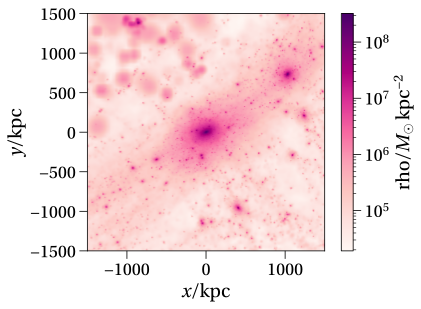

In [12]:
pynbody.analysis.halo.center(h[0], vel=False)
pynbody.plot.sph.image(f.dm[pynbody.filt.Sphere("3 Mpc")], width="3 Mpc", units="Msol kpc^-2")

But close into the halo, things look just fine! 

SimArray([[163659.66  , 163732.97  , 163806.31  , ...,  37355.574 ,
            36377.766 ,  35399.945 ],
          [161643.86  , 162055.73  , 162467.62  , ...,  38346.535 ,
            37402.203 ,  36457.875 ],
          [159628.08  , 160378.5   , 161128.92  , ...,  39337.484 ,
            38426.64  ,  37515.81  ],
          ...,
          [ 15308.417 ,  15604.361 ,  15900.306 , ..., 188634.77  ,
           185448.4   , 182262.08  ],
          [ 14378.8955,  14678.231 ,  14977.568 , ..., 189044.89  ,
           185905.7   , 182766.56  ],
          [ 13449.373 ,  13752.103 ,  14054.83  , ..., 189455.    ,
           186363.02  , 183271.06  ]], dtype=float32, 'Msol kpc**-2')

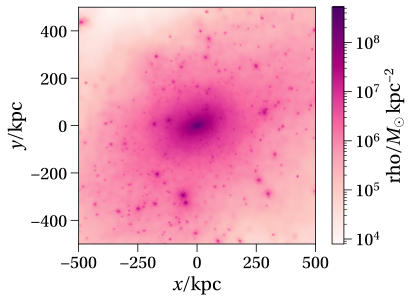

In [13]:
pynbody.analysis.halo.center(h[0], vel=False)
pynbody.plot.sph.image(f.dm[pynbody.filt.Sphere("1 Mpc")], width="1 Mpc", units="Msol kpc^-2")

The unzoomed virial radius was 371 kpc, let's find out what it is now we've zoomed — it will have changed a bit, but hopefully not too much!

In [14]:
pynbody.analysis.halo.virial_radius(f.dm)

SimArray(368.8894819, 'kpc')

Let's find the closest "heavy" particle to the halo centre, to check we are not contaminated by non-zoomed particles:

In [15]:
f.dm['r'][f.dm['mass']>f.dm['mass'].min()].min()

SimArray(919.56854, dtype=float32, 'kpc')

It's a whole Mpc away, probably overkill, resulting from adding in an extra cell around the strict Lagrangian patch (which was 750 kpc at z=0). In a hydro run where CPU time is an issue, you might flag a smaller region and if you find any contaminating particles on an initial trial DMO, you can revisit the exact definition of the zoom region to compensate. GenetIC offers cunning ways to do this using input mappers. However, to keep things simple, let's move on for now and find the accretion history of this halo.

For a robust and scalable approach to this, you might use a tool like [tangos](https://pynbody.github.io/tangos/). But let's keep it simple and just assume the halo with the most particles will always be our major progenitor (this is often correct in a zoom simulation). Now I can make a simple mass accretion history like this:

In [16]:
def make_accretion_history(folder):
    import glob

    zs = []
    masses = []

    for f in sorted(glob.glob(f"{folder}/gadget_output/snapshot_???.hdf5"))[1:]:
        snap = pynbody.load(f)
        z = snap.properties['z']
        h = snap.halos()
        mass = h[0].sub[0]['mass'].in_units("Msol").sum()
        zs.append(z)
        masses.append(mass)

    to_write = np.asarray([zs,masses]).T

    np.savetxt(f'{folder}/accretion_history.txt',to_write,fmt='%.2f %.2e',header='Redshift Mass/Msol')

In [17]:
#### WARNING: DON'T RUN THIS CELL FOR YOURSELF UNLESS YOU'VE ACTUALLY RUN THE SIMULATION!
#### Otherwise, it will overwrite the accretion history that I previously calculated
make_accretion_history("step_2_zoom")

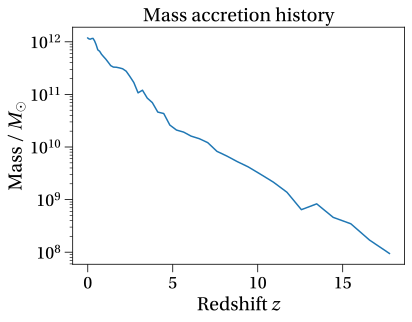

In [18]:
def plot_accretion_history(folder, **kwargs):
    z, mass = np.loadtxt(f"{folder}/accretion_history.txt", unpack=True)
    p.plot(z,mass,**kwargs)
    p.semilogy()
    p.xlabel("Redshift $z$")
    p.ylabel("Mass / $M_{\odot}$")
    p.title("Mass accretion history")
    
plot_accretion_history("step_2_zoom")

Modifying the collapse time
---

The goal of this tutorial is to change the mass accretion history of this halo, while maintaining its $z=0$ mass. 

There is no _guaranteed_ way to do this by modifying the linear initial conditions. However, extended Press Schechter theory gives us a good guideline: the collapse time of a region depends on its mean linear overdensity. So, if we fix the linear overdensity of the $z=0$ halo, while increasing the linear overdensity of an earlier progenitor (here I'll choose $z\sim 5$, but the results are not very sensitive to that choice), we should hasten the early collapse, but still get the same mass at $z=0$.

There are many other things you can do with GM, such as changing a chosen merger ratio. A separate tutorial by Jon Davies shows how to accomplish that -- it requires a bit more care with identifying progenitors etc.

In [19]:
f_z0 = pynbody.load("step_2_zoom/gadget_output/snapshot_047.hdf5")
f_z5 = pynbody.load("step_2_zoom/gadget_output/snapshot_019.hdf5")

In [20]:
# check I've opened the right files:
print(f"Redshifts of chosen snapshots are {f_z0.properties['z']:.2f}, {f_z5.properties['z']:.2f}")

Redshifts of chosen snapshots are -0.00, 4.83


In [21]:
# That's as close as we can get! Let's go ahead and write the particle IDs, to allow
# genetIC to locate the regions we will want to change (z=5) and fix (z=0)

h_z0 = f_z0.halos()
h_z5 = f_z5.halos()

np.savetxt(f"step_3_modify/halo_z0_particles.txt", h_z0[0]['iord'], fmt="%d")
np.savetxt(f"step_3_modify/progenitor_z5_particles.txt", h_z5[0]['iord'], fmt="%d")

Now take a look at step_3_modify/paramfile.txt, which explains how to generate modified ICs starting from these ID files. And then, let's run it!

In [22]:
!../genetIC/genetIC/genetIC step_3_modify/paramfile.txt

genetIC v1.3.6, compiled: Jun 18 2022, 09:52:50
                 runtime: Jun 23 2022, 20:09:31

git HEAD:eeb7f12
 2022-06-23 20:09:31   
 2022-06-23 20:09:31   Limiting number of FFTW Threads to 8, because FFTW on Mac OS seems to become slow beyond this point.
 2022-06-23 20:09:31   To disable this behaviour, recompile with -DIGNORE_APPLE_FFTW_THREAD_LIMIT
 2022-06-23 20:09:31   OpenMP parts of the code will still run with 20 threads.
 2022-06-23 20:09:31   
 2022-06-23 20:09:31   Initialized the base grid:
 2022-06-23 20:09:31     Box length            = 50 Mpc/h
 2022-06-23 20:09:31     n                     = 128
 2022-06-23 20:09:31     dx                    = 0.390625
 2022-06-23 20:09:31   Centre of region is 30.2422531513 6.49947478992 19.5772058824
 2022-06-23 20:09:31   Expand flagged region by 1 cells
 2022-06-23 20:09:31     - level 0 increased number of flagged cells by 468 (now 706)
 2022-06-23 20:09:31   Initialized a zoom region:
 2022-06-23 20:09:31     Subbox length  

You'll see that genetIC reports a $\Delta \chi^2 \simeq 5$, and might mentally translate that into the modified object being $e^{5/2} \simeq 12$ times less common than the original. But beware! There are Jacobian factors and degeneracies that mediate between the likelihood of the initial conditions and the abundance of the final objects. The $\Delta \chi^2$ is indicative of the magnitude of the change, but it would be very wrong to expect it to reflect object abundances. See [Roth et al 2016](https://arxiv.org/pdf/1504.07250.pdf) for some discussion on this point.

Understanding the modifications
-------------------------------

To understand the modifications, I am going to use a python tool that comes with genetIC called `plotslice`. There is a copy of this tool in the tutorial folder to make life easy. The tool, as the name suggests, is a convenient way to plot slices of the ICs. It relies on having "dumped" the density fields into numpy format, which we did using the command `dump_grid` at the bottom of the genetIC parameter files in the previous steps.

Let's first take a look at the ICs before we made any modifications.

In [23]:
import plotslice

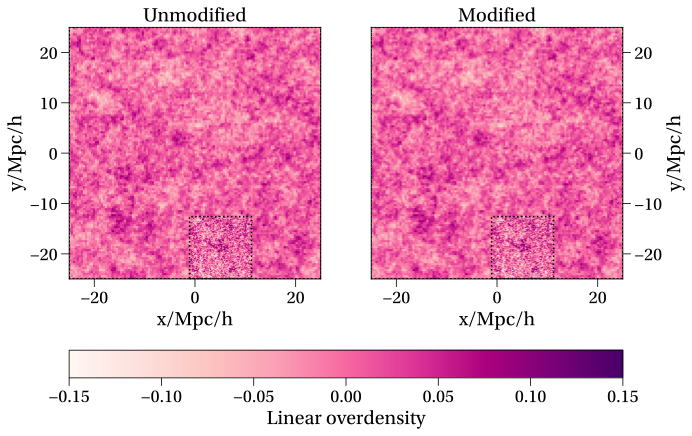

In [24]:
p.figure(figsize=(10,8))
p.subplot(121)
plotslice.plotslice("step_2_zoom/", slice=19.2) 
p.title("Unmodified")

p.subplot(122)
plotslice.plotslice("step_3_modify/", slice=19.2)

p.gca().yaxis.tick_right()
p.gca().yaxis.set_label_position('right')
p.title("Modified")


p.colorbar(ax=p.gcf().axes,location='bottom').set_label("Linear overdensity")


# slice=19.2 just means we look at an x-y slice with the z coorinate set to 19.2 -- this is where the modifications are being made 
# (you can read this off the genetIC output, where it tells you the centre of regions it is changing)

In the above, you can see the zoom region outlined with a dotted line. **By eye, the modified and unmodified zoom regions are pretty hard to distinguish.** So let's now plot the difference between them to understand what happened.

Attempt to compare grid 0 in 'step_3_modify/' to grid 0 in 'step_2_zoom/'
Attempt to compare grid 1 in 'step_3_modify/' to grid 1 in 'step_2_zoom/'


Text(0.5, 1.0, 'Difference plot')

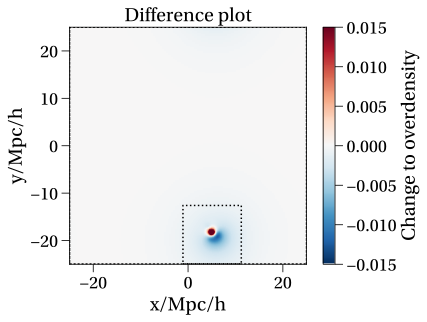

In [25]:
p.set_cmap("RdBu_r")
plotslice.plotslice("step_3_modify/", diff_prefix="step_2_zoom/", slice=19.2, vmin=-0.015, vmax=0.015)
p.colorbar().set_label(r"Change to overdensity")
p.title("Difference plot")

Here notice **the colour scale is exaggerated by a factor of 10 relative to the colour scale in the original density plots**. You can see that genetIC has increased parts of the overdensity, and decreased others. The shape is quite complicated, because it is determined by the way the z=0 and z=5 halo particles overlap in the initial conditions. Let's have a zoomed in view and exaggerate the colour scale still further to see all this clearly:

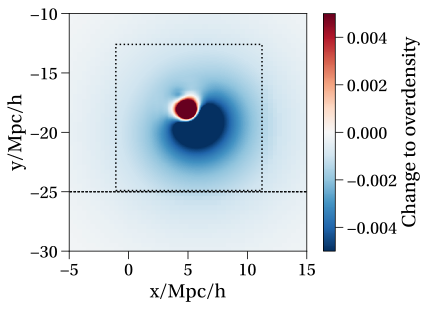

In [26]:
p.set_cmap("RdBu_r")
plotslice.plotslice("step_3_modify/", diff_prefix="step_2_zoom/", slice=19.2, vmin=-0.005, vmax=0.005)
p.xlim(-5,15)
p.ylim(-30,-10)
p.colorbar().set_label(r"Change to overdensity")

The horizontal dotted line here is showing where the edges of the volume wrap around, so in this case the modifications are wrapping around the box (though of course we are now looking at a very exaggerated colour scale -- around 3% relative to the original fluctuations). 

In [27]:
f = pynbody.load("step_2_zoom/zoom.gadget3")
z0_iords = np.loadtxt("step_3_modify/halo_z0_particles.txt", dtype=int)
z5_iords = np.loadtxt("step_3_modify/progenitor_z5_particles.txt", dtype=int)


# When generating the ICs, we made the zoom particle output centred on (25,25,25). 
# To put the coordinates back into alignment with the original grids (being plotted above)
# we need to recentre them. The centre can be read from the genetIC output in the step_2_zoom case; 
# the last time it says "centre of region" before output determines the offset.

f.dm['pos'] += (30.2422531513,6.49947478992,19.5772058824)

# We need to wrap these points round the box now:
f.dm['pos'] -= (50.0,50.0,50.0)


# and here's the thin slice that is being plotted in the overdensity difference maps

sl = pynbody.filt.BandPass('z',19.1-25.0, 19.3-25.0)

# now let's find the convex hull of the particles we flagged, so that we can find out where
# they are relative to the modifications

from scipy.spatial import ConvexHull
hull_z0 = ConvexHull(f.dm[z0_iords][sl]['pos'][:,:2])
hull_z5 = ConvexHull(f.dm[z5_iords][sl]['pos'][:,:2])


# will want to plot them:

def plot_hull(hull,**kwargs):
    p.plot(hull.points[hull.vertices,0], hull.points[hull.vertices,1], **kwargs)



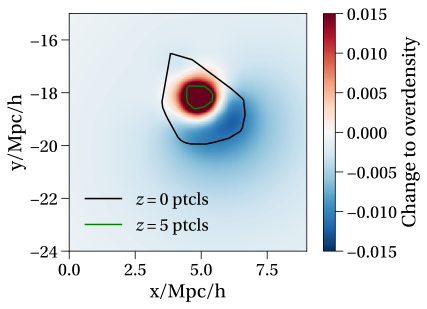

In [28]:
p.set_cmap("RdBu_r")
plotslice.plotslice("step_3_modify/", diff_prefix="step_2_zoom/", slice=19.2, vmin=-0.015, vmax=0.015)
p.xlim(0,9)
p.ylim(-24,-15)
p.colorbar().set_label(r"Change to overdensity")
plot_hull(hull_z0, label="$z=0$ ptcls", color="k")
plot_hull(hull_z5, label="$z=5$ ptcls", color="g")
p.legend()

Running the modified zoom simulation
---------------------------------

If you managed to run the original zoom simulation, running the modified one is easy; you just do exactly the same, but with the new ICs!

Once gadget has completed, you can make an accretion history using the same approach from earlier.

In [29]:
# DO NOT RUN THIS CELL unless you have actually performed the simulation!
#
# It will overwrite my results with a useless file unless the Gadget output is in place.

make_accretion_history("step_3_modify")

So now, let's see if it worked... is the accretion history any different?

**Drumroll, please...**

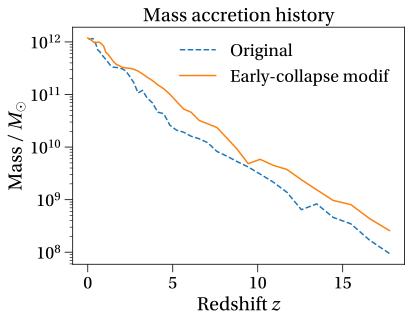

In [30]:
plot_accretion_history("step_2_zoom", label="Original", linestyle="dashed")
plot_accretion_history("step_3_modify", label="Early-collapse modif")
p.legend()

**Success!**

The halo is collapsing earlier. But is the environment of the halo otherwise the same? This is the key central point of GM: we're hoping for _minimal_ changes. Let's plot an image of the two simulations side by side. We'll zoom out into the environment a bit, so you'll see the 'heavy' particles encroaching on the zoom region as we did before. But that's not a problem, we just need to see if things look similar between the two simulations.

In [31]:
f_orig = pynbody.load("step_2_zoom/gadget_output/snapshot_047.hdf5")
f_orig.physical_units()
h_orig = f_orig.halos()
pynbody.analysis.halo.center(h_orig[0])

f = pynbody.load("step_3_modify/gadget_output/snapshot_047.hdf5")
f.physical_units()
h = f.halos()
pynbody.analysis.halo.center(h[0])

**Another drumroll, please...**

<Figure size 432x288 with 0 Axes>

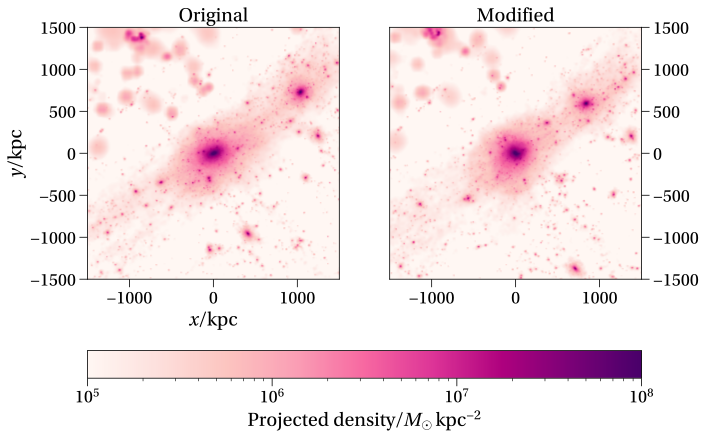

In [32]:
p.set_cmap("RdPu")
p.figure(figsize=(10,8))
p.subplot(121)
pynbody.plot.sph.image(f_orig.dm[pynbody.filt.Sphere("3 Mpc")], width="3 Mpc", units="Msol kpc^-2", 
                       subplot=p.gca(), show_cbar = False, vmin=1e5, vmax=1e8)
p.title("Original")

p.subplot(122)
im = pynbody.plot.sph.image(f.dm[pynbody.filt.Sphere("3 Mpc")], width="3 Mpc", units="Msol kpc^-2", 
                            subplot=p.gca(), show_cbar = False, vmin=1e5, vmax=1e8, ret_im = True)
p.gca().yaxis.tick_right()
p.gca().yaxis.set_label_position('right')
p.title("Modified")

p.colorbar(ax=p.gcf().axes,location='bottom',mappable=im).set_label(r"Projected density/$M_{\odot}\,\mathrm{kpc}^{-2}$")


 **Yes!** The two simulations look pretty similar. You'll notice some of the nearby halos have shifted around a bit. This is indeed a natural consequence of GM: its changes are _minimal_ but they cannot be _completely local_ because they must be consistent with cosmology. We saw the changes extend outwards when we examined the ICs earlier on. There is some more discussion of this in [Pontzen et al 2017](https://arxiv.org/pdf/1607.02507.pdf), see Fig 1 especially.
 
 Now the concentration -- collapse time relation in the population suggests that our early-collapse halo should be more centrally concentrated; in [Roth et al 2016](https://arxiv.org/pdf/1504.07250.pdf) we showed this indeed held on an object-by-object basis within GM. Let's check we can recreate it now:

/Users/app/Science/pynbody/pynbody/array.py:353: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/Users/app/Science/pynbody/pynbody/array.py:353: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)


(1000.0, 10000000.0)

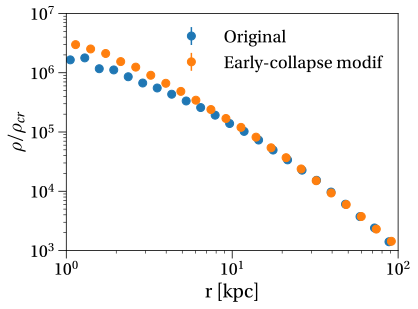

In [33]:
pynbody.plot.density_profile(h_orig[0])
pynbody.plot.density_profile(h[0], clear=False)
p.legend(["Original", "Early-collapse modif"])
p.xlim(1.0,100) 
# note I set a softening scale of ~1kpc on both simulations in gadget_param.txt, so shouldn't look below ~2 kpc in the result below
p.ylim(1e3,1e7)

**Success!** The early collapser is indeed more centrally concentrated.

The big advantage of GM: now you can pose and test your hypothesis
------------------------------------------------------------------

Almost certainly, you don't want to stop with one genetically modified IC. In `step_4_modify_again` you'll find a very simply changed `paramfile.txt` which has increased the strength of the modification to 40% (instead of 20%). This should make things collapse even earlier. Let's generate the ICs, and run the simulation.

In [34]:
!../genetIC/genetIC/genetIC step_4_modify_again/paramfile.txt

genetIC v1.3.6, compiled: Jun 18 2022, 09:52:50
                 runtime: Jun 23 2022, 20:12:04

git HEAD:eeb7f12
 2022-06-23 20:12:04   
 2022-06-23 20:12:04   Limiting number of FFTW Threads to 8, because FFTW on Mac OS seems to become slow beyond this point.
 2022-06-23 20:12:04   To disable this behaviour, recompile with -DIGNORE_APPLE_FFTW_THREAD_LIMIT
 2022-06-23 20:12:04   OpenMP parts of the code will still run with 20 threads.
 2022-06-23 20:12:04   
 2022-06-23 20:12:04   Initialized the base grid:
 2022-06-23 20:12:04     Box length            = 50 Mpc/h
 2022-06-23 20:12:04     n                     = 128
 2022-06-23 20:12:04     dx                    = 0.390625
 2022-06-23 20:12:04   Centre of region is 30.2422531513 6.49947478992 19.5772058824
 2022-06-23 20:12:04   Expand flagged region by 1 cells
 2022-06-23 20:12:04     - level 0 increased number of flagged cells by 468 (now 706)
 2022-06-23 20:12:04   Initialized a zoom region:
 2022-06-23 20:12:04     Subbox length  

You'll see that genetIC is now reporting $\Delta \chi^2 \simeq 11.3$. As I cautioned above, you can't directly translate this into an object abundance, but this change is clearly more dramatic than the original. (Note that the reduced $\chi^2$ of the ICs is still absolutely fine, given the enormous number of degrees of freedom!) 

Let's see if it succeeded in making quite an extreme early collapse object

In [35]:
make_accretion_history("step_4_modify_again")

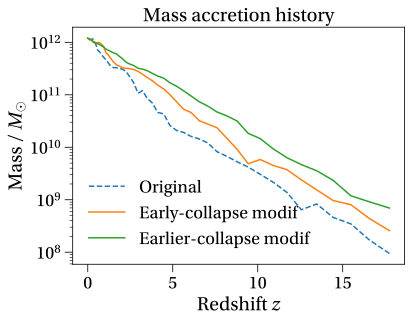

In [36]:
plot_accretion_history("step_2_zoom", label="Original", linestyle="dashed")
plot_accretion_history("step_3_modify", label="Early-collapse modif")
plot_accretion_history("step_4_modify_again", label="Earlier-collapse modif")
p.legend()

It looks good to me! At $z=5$, we've now got something that's almost an order of magnitude more massive than it was, while the $z=0$ mass is still fixed. 

And that's it for this tutorial.

Go forth and modify!
------------------

We are happy to help anyone who's trying to use genetIC. We can't offer guarantees but will help to the best of our ability.

The best way to raise help is usually with a github issue. 